In [94]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import platform
import roadrunner
import math

# Silence RoadRunner log messages completely
roadrunner.Logger.setLevel(roadrunner.Logger.LOG_CRITICAL)

# Cross-platform path detection
def get_model_path():
    """Get the correct path to the SBML model file based on OS and available paths."""
    # Define possible paths
    linux_path = "/home/gijs/Documents/OxfordEvolution/Yeast/Chen/chen2004_biomd56.xml"
    mac_path = "/Users/gijsbartholomeus/Documents/STUDIE/OxfordEvolution/code/Yeast/Chen/chen2004_biomd56.xml"
    
    # Check which path exists
    if os.path.exists(linux_path):
        return linux_path
    elif os.path.exists(mac_path):
        return mac_path
    else:
        # Fallback: try to find it relative to current directory
        possible_relative_paths = [
            "chen2004_biomd56.xml",
            "Chen/chen2004_biomd56.xml",
            "../Chen/chen2004_biomd56.xml"
        ]
        for rel_path in possible_relative_paths:
            if os.path.exists(rel_path):
                return os.path.abspath(rel_path)
        
        # If nothing found, raise an error with helpful message
        raise FileNotFoundError(
            f"Could not find chen2004_biomd56.xml in any of the expected locations:\n"
            f"  Linux: {linux_path}\n"
            f"  Mac: {mac_path}\n"
            f"Current working directory: {os.getcwd()}\n"
            f"Platform: {platform.system()}"
        )

# Load Chen 2004 budding yeast cell cycle model
model_path = get_model_path()
print(f"Loading model from: {model_path}")
rr = te.loadSBMLModel(model_path)



Loading model from: /Users/gijsbartholomeus/Documents/STUDIE/OxfordEvolution/code/Yeast/Chen/chen2004_biomd56.xml


Testing with fresh model...
Parameter breakdown:
  Kinetic parameters: 156
  Excluded parameters: 7 - ['CDC15T', 'ESP1T', 'IET', 'kdirent', 'ksn2_p', 'kspds_p', 'TEM1T']
  Expected: 156 parameters

Testing original model parameters...
✓ Original model simulates successfully

=== WILDTYPE PHENOTYPE TEST ===
Wildtype encoding: 00011111111111111111100000001111111111111111111000
Wildtype complexity (CLZ): 56.439
Wildtype sampled parameter count: 136 (all should be 1.0)

=== RANDOMIZED PHENOTYPE TEST ===


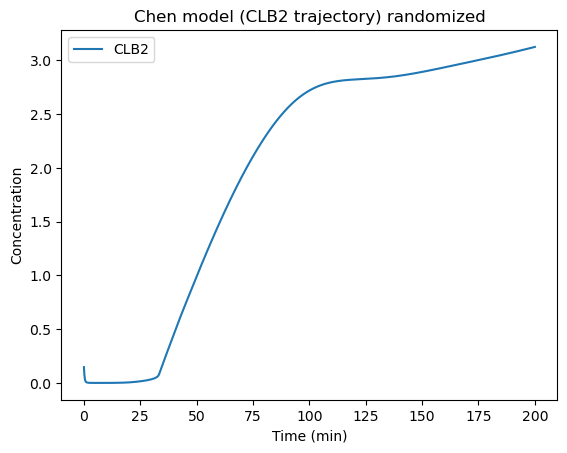

Sampled params = [0.75, 1.25, 2.0, 1.75, 1.0, 1.25, 0.75, 0.5, 2.0, 1.5, 1.25, 1.5, 2.0, 2.0, 1.25, 0.25, 2.0, 1.25, 2.0, 0.5, 1.25, 2.0, 0.25, 0.5, 0.25, 1.25, 1.75, 0.5, 0.5, 1.25, 0.5, 1.0, 0.5, 0.5, 1.5, 1.5, 0.25, 1.0, 0.25, 1.5, 0.5, 1.75, 0.25, 1.5, 1.0, 1.0, 1.0, 1.25, 1.25, 0.75, 0.75, 1.5, 1.75, 0.5, 1.75, 0.75, 2.0, 1.75, 0.75, 0.75, 1.0, 0.25, 1.5, 0.25, 2.0, 2.0, 1.25, 2.0, 1.5, 0.25, 2.0, 0.25, 2.0, 1.75, 2.0, 0.25, 2.0, 1.5, 1.25, 1.25, 1.75, 1.75, 1.5, 0.75, 0.5, 1.5, 2.0, 0.25, 0.5, 0.25, 1.0, 2.0, 1.25, 0.25, 1.75, 1.75, 1.25, 1.25, 0.75, 0.75, 0.75, 1.5, 1.75, 1.5, 1.0, 0.25, 1.5, 1.25, 0.25, 1.75, 1.25, 0.5, 0.75, 1.5, 1.25, 0.5, 2.0, 1.75, 1.0, 1.0, 0.75, 1.0, 0.75, 1.75, 1.25, 2.0, 0.25, 1.0, 1.25, 0.5, 0.75, 0.75, 1.0, 0.5, 0.25, 1.75]
Sampled parameter count: 136
Up-Down encoding: 01111111111111111111111111111111111111111111111111 ...
Lempel-Ziv complexity (CLZ): 39.50699332842307


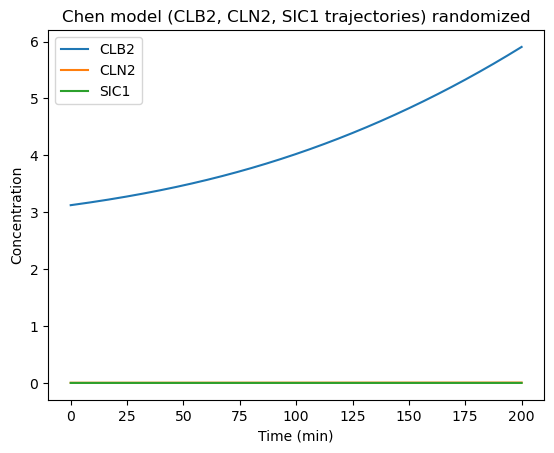

In [ ]:
multipliers = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00]

def get_kinetic_parameters(rr):
    """Get list of kinetic parameters, excluding regulatory switches/flags."""
    kinetic_params = []
    excluded_params = []
    
    for pid in rr.getGlobalParameterIds():
        value = rr.getValue(pid)
        param_lower = pid.lower()
        
        # Exclude non-kinetic parameters (switches, flags, totals)
        if (param_lower.endswith('t') and value in [0.0, 1.0]) or \
           (param_lower.startswith('d') and param_lower.endswith('n')) or \
           ('flag' in param_lower) or \
           ('switch' in param_lower) or \
           (value == 0.0) or \
           (pid in ['cell']) or \
           ('total' in param_lower and value in [0.0, 1.0]):
            excluded_params.append(pid)
        else:
            kinetic_params.append(pid)
    
    return kinetic_params, excluded_params

def sample_parameters(rr, wildtype=False):
    """Scale only kinetic parameters by random factors (matches paper's 156 parameters).
    Excludes regulatory switches and flags to match the paper exactly."""
    
    # First, reset the model to ensure clean state
    rr.resetAll()
    
    # Get kinetic parameters only
    kinetic_params, excluded_params = get_kinetic_parameters(rr)
    
    sampled = {}
    sampled_values = []  # Just the values for quick printing
    
    # Sample only kinetic parameters
    for pid in kinetic_params:
        try:
            current = rr.getValue(pid)
            factor = 1.0 if wildtype else random.choice(multipliers)
            rr.setValue(pid, current * factor)
            sampled[pid] = factor
            sampled_values.append(factor)
        except RuntimeError:
            continue
    
    # Keep excluded parameters at their original values (don't sample them)
    # This ensures regulatory switches stay fixed
    
    return sampled, sampled_values

def simulate_and_extract(rr, tmax=200, npoints=2001):
    rr.selections = ["time"] + rr.getFloatingSpeciesIds()
    try:
        result = rr.simulate(0, tmax, npoints)
    except RuntimeError as e:
        # Any CVODE failure: return None
        return None, None

    time = result[:, 0]
    cols = rr.selections

    clb2 = result[:, cols.index("CLB2")]
    signal = clb2  # Use only CLB2, not the product
    return time, signal

def up_down_encoding(time, signal, nbins=50):
    """Binary string of slope signs at evenly spaced time bins.
    Following Fink method: evaluate slopes at δt, 2δt, ..., T (starting at δt)."""
    bits = []
    dt = (time[-1] - time[0]) / nbins  # bin width
    
    # Start from the first bin edge (δt), not from t=0
    for i in range(1, nbins + 1):
        t_eval = time[0] + i * dt  # δt, 2δt, 3δt, ...
        
        # Ensure we don't go beyond the time series
        if t_eval > time[-1]:
            break
            
        # Get signal values at t_eval and slightly before
        t_before = t_eval - dt/10  # Small step back to compute slope
        if t_before < time[0]:
            t_before = time[0]
            
        val_before = np.interp(t_before, time, signal)
        val_now = np.interp(t_eval, time, signal)
        
        slope = val_now - val_before
        bits.append("1" if slope >= 0 else "0")
    
    return "".join(bits)

def lz76_phrase_count(s: str) -> int:
    n = len(s)
    if n == 0:
        return 0
    i = 0
    c = 1  # at least one phrase if n>0
    k = 1
    while i + k <= n:
        if s[i:i+k] in s[:i]:
            k += 1
            if i + k - 1 > n:
                c += 1
                break
        else:
            c += 1
            i += k
            k = 1
    return c

def CLZ(x):
    """Lempel-Ziv complexity as described in the prompt."""
    n = len(x)
    if x.count('0') == n or x.count('1') == n:
        return math.log2(n)
    else:
        return math.log2(n) / 2 * (lz76_phrase_count(x) + lz76_phrase_count(x[::-1]))

# --- Main workflow ---
wildtype = False  # Set to True for wildtype, False for randomized

# Test with a fresh model load to ensure clean state
print("Testing with fresh model...")
rr_test = te.loadSBMLModel(model_path)

# Show parameter breakdown
kinetic_params, excluded_params = get_kinetic_parameters(rr_test)
print(f"Parameter breakdown:")
print(f"  Kinetic parameters: {len(kinetic_params)}")
print(f"  Excluded parameters: {len(excluded_params)} - {excluded_params}")
print(f"  Expected: 156 parameters")

# Try simulation without any parameter changes first
print("\nTesting original model parameters...")
try:
    test_result = rr_test.simulate(0, 200, 2001)
    print("✓ Original model simulates successfully")
except RuntimeError as e:
    print(f"✗ Original model fails: {e}")
    print("This suggests an issue with the model file itself")

# Test wildtype phenotype first
print("\n=== WILDTYPE PHENOTYPE TEST ===")
rr_wildtype = te.loadSBMLModel(model_path)
sampled_params_wt, sampled_values_wt = sample_parameters(rr_wildtype, wildtype=True)
time_wt, clb2_wt = simulate_and_extract(rr_wildtype)

if time_wt is None or clb2_wt is None:
    print("WARNING: Wildtype simulation failed!")
else:
    encoding_wt = up_down_encoding(time_wt, clb2_wt, nbins=50)
    complexity_wt = CLZ(encoding_wt)
    print(f"Wildtype encoding: {encoding_wt}")
    print(f"Wildtype complexity (CLZ): {complexity_wt:.3f}")
    print(f"Wildtype sampled parameter count: {len(sampled_values_wt)} (all should be 1.0)")

# Now test our parameter sampling with randomization
print("\n=== RANDOMIZED PHENOTYPE TEST ===")
sampled_params, sampled_values = sample_parameters(rr_test, wildtype=wildtype)
time, clb2 = simulate_and_extract(rr_test)  # Only CLB2 returned now

if time is None or clb2 is None:
    print("WARNING: Integration failed for this parameter set!")

    print("Skipping plots due to simulation failure.")
else:
    encoding = up_down_encoding(time, clb2, nbins=50)

    # Plot CLB2 trajectory
    plt.plot(time, clb2, label="CLB2")
    plt.xlabel("Time (min)")
    plt.ylabel("Concentration")
    plt.title(f"Chen model (CLB2 trajectory) {'wildtype' if wildtype else 'randomized'}")
    plt.legend()
    plt.show()

    # Print sampled parameters as array
    print(f"Sampled params = {sampled_values}")
    print(f"Sampled parameter count: {len(sampled_values)}")

    print("Up-Down encoding:", encoding[:120], "...")
    print("Lempel-Ziv complexity (CLZ):", CLZ(encoding))

    # Plot CLB2, CLN2, SIC1 individually - only if first simulation succeeded
    try:
        result = rr_test.simulate(0, 200, 2001)
        cols = rr_test.selections
        plt.figure()
        plt.plot(time, result[:, cols.index("CLB2")], label="CLB2")
        plt.plot(time, result[:, cols.index("CLN2")], label="CLN2")
        plt.plot(time, result[:, cols.index("SIC1")], label="SIC1")
        plt.xlabel("Time (min)")
        plt.ylabel("Concentration")
        plt.title(f"Chen model (CLB2, CLN2, SIC1 trajectories) {'wildtype' if wildtype else 'randomized'}")
        plt.legend()
        plt.show()
    except RuntimeError as e:
        print(f"WARNING: Second simulation failed: {e}")
        print("Showing only CLB2 plot from first successful simulation.")


# Number of samples (use small first, scale up later)

In [104]:
test='01010101'
print(f"String: {test}")
print(f"Length: {len(test)}")
print(f"lz76_phrase_count('{test}') = {lz76_phrase_count(test)}")
print(f"lz76_phrase_count('{test[::-1]}') = {lz76_phrase_count(test[::-1])}")
print(f"CLZ('{test}') = {CLZ(test)}")

# Let's trace through lz76_phrase_count step by step
def lz76_phrase_count_debug(s: str) -> int:
    """Debug version of lz76_phrase_count with print statements"""
    n = len(s)
    if n == 0:
        return 0
    i = 0
    c = 1  # at least one phrase if n>0
    k = 1
    print(f"\nTracing lz76_phrase_count for '{s}':")
    print(f"Starting: i=0, c=1, k=1")
    
    while i + k <= n:
        print(f"\nAt position {i}, checking substring '{s[i:i+k]}'...")
        
        if s[i:i+k] in s[:i]:
            print(f"  '{s[i:i+k]}' found in prefix '{s[:i]}'")
            k += 1
            if i + k - 1 > n:
                print(f"  Reached end, incrementing count")
                c += 1
                break
        else:
            print(f"  '{s[i:i+k]}' not found in prefix '{s[:i]}' - new phrase")
            c += 1
            i += k
            k = 1
            print(f"  New state: i={i}, c={c}, k={k}")
    
    return c

print("\n" + "="*50)
result = lz76_phrase_count_debug(test)

String: 01010101
Length: 8
lz76_phrase_count('01010101') = 4
lz76_phrase_count('10101010') = 4
CLZ('01010101') = 12.0


Tracing lz76_phrase_count for '01010101':
Starting: i=0, c=1, k=1

At position 0, checking substring '0'...
  '0' not found in prefix '' - new phrase
  New state: i=1, c=2, k=1

At position 1, checking substring '1'...
  '1' not found in prefix '0' - new phrase
  New state: i=2, c=3, k=1

At position 2, checking substring '0'...
  '0' found in prefix '01'

At position 2, checking substring '01'...
  '01' found in prefix '01'

At position 2, checking substring '010'...
  '010' not found in prefix '01' - new phrase
  New state: i=5, c=4, k=1

At position 5, checking substring '1'...
  '1' found in prefix '01010'

At position 5, checking substring '10'...
  '10' found in prefix '01010'

At position 5, checking substring '101'...
  '101' found in prefix '01010'


250/5000 (5.0%) | success: 250 | skip: 0 | elapsed: 0.5m | ETA: 14:03 (10.4m left)
500/5000 (10.0%) | success: 500 | skip: 0 | elapsed: 1.1m | ETA: 14:03 (9.5m left)
500/5000 (10.0%) | success: 500 | skip: 0 | elapsed: 1.1m | ETA: 14:03 (9.5m left)
750/5000 (15.0%) | success: 750 | skip: 0 | elapsed: 1.6m | ETA: 14:03 (8.9m left)
750/5000 (15.0%) | success: 750 | skip: 0 | elapsed: 1.6m | ETA: 14:03 (8.9m left)
1000/5000 (20.0%) | success: 1000 | skip: 0 | elapsed: 2.1m | ETA: 14:03 (8.3m left)
1000/5000 (20.0%) | success: 1000 | skip: 0 | elapsed: 2.1m | ETA: 14:03 (8.3m left)
1250/5000 (25.0%) | success: 1250 | skip: 0 | elapsed: 2.6m | ETA: 14:03 (7.7m left)
1250/5000 (25.0%) | success: 1250 | skip: 0 | elapsed: 2.6m | ETA: 14:03 (7.7m left)
1500/5000 (30.0%) | success: 1500 | skip: 0 | elapsed: 3.1m | ETA: 14:03 (7.2m left)
1500/5000 (30.0%) | success: 1500 | skip: 0 | elapsed: 3.1m | ETA: 14:03 (7.2m left)
1750/5000 (35.0%) | success: 1750 | skip: 0 | elapsed: 3.6m | ETA: 14:03 (6

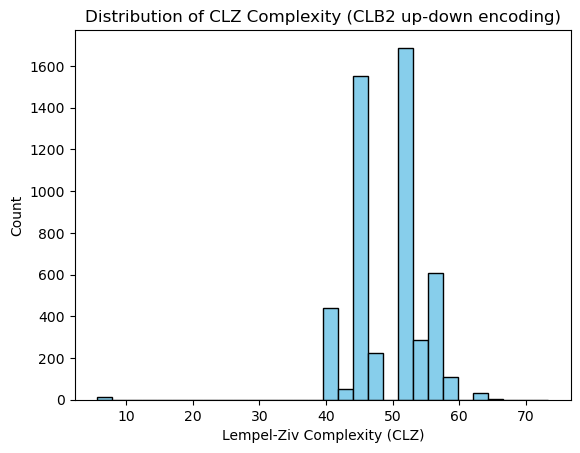

Wildtype phenotype not found in sampled set.


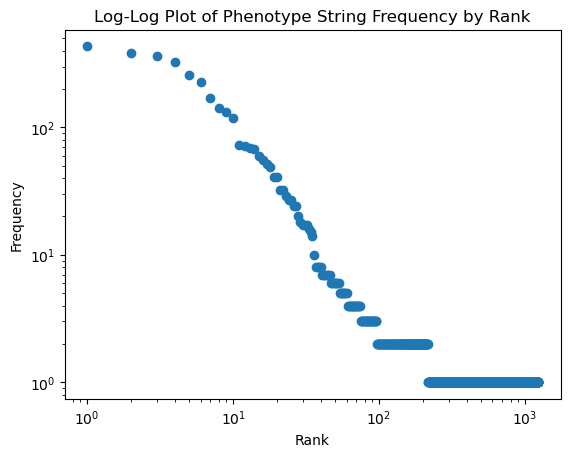

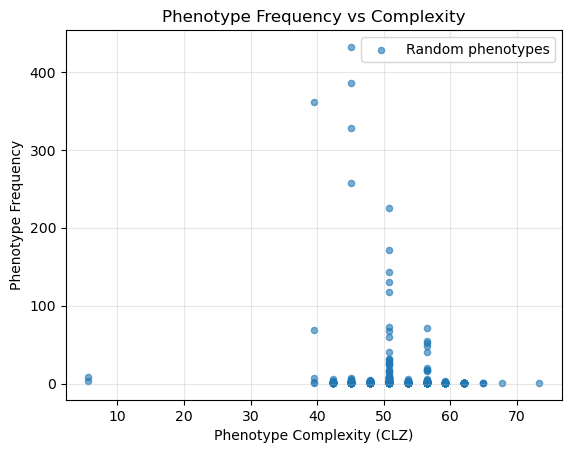

In [93]:
import matplotlib.pyplot as plt
from collections import Counter
import time
from datetime import datetime, timedelta

def print_progress(i, total, start_time, successful_count, skipped_count, interval=0.05):
    """Print progress every 'interval' fraction of total samples"""
    # Use exact percentage to avoid double printing
    progress_pct = (i+1) / total * 100
    milestone_pct = round(progress_pct / (interval * 100)) * (interval * 100)
    
    # Only print at exact milestones
    if abs(progress_pct - milestone_pct) < 0.01 and (i == 0 or progress_pct > getattr(print_progress, 'last_printed', 0)):
        elapsed = time.time() - start_time
        progress = (i+1) / total
        eta = datetime.now() + timedelta(seconds=elapsed / progress * (1 - progress))
        print(f"{i+1}/{total} ({progress*100:.1f}%) | success: {successful_count} | skip: {skipped_count} | "
              f"elapsed: {elapsed/60:.1f}m | ETA: {eta.strftime('%H:%M')} ({elapsed/progress*(1-progress)/60:.1f}m left)")
        print_progress.last_printed = progress_pct

N = 5000
encodings = []
complexities = []
skipped_count = 0
start_time = time.time()

print("Starting parameter sampling loop...")
print("Process: Load fresh model -> Randomize parameters -> Simulate -> Extract phenotype -> Reset")

for i in range(N):
    # RESET: Load fresh model (this resets all parameters to original values)
    rr = te.loadSBMLModel(model_path)  
    
    # RANDOMIZE: Sample new random multipliers for kinetic parameters only
    sample_parameters(rr)  # This applies random multipliers from [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00]
    
    # SIMULATE: Run simulation with randomized parameters
    time_sim, clb2 = simulate_and_extract(rr)

    if time_sim is None or clb2 is None:
        skipped_count += 1
        continue

    # SAVE PHENOTYPE: Extract and store the phenotype encoding
    encoding = up_down_encoding(time_sim, clb2, nbins=50)
    encodings.append(encoding)
    complexities.append(CLZ(encoding))
    
    print_progress(i, N, start_time, len(encodings), skipped_count)
    # Model automatically discarded at end of loop iteration

print(f"\nFinal: {len(encodings)} successful, {skipped_count} skipped")
print("Example encoding:", encodings[0][:120], "...")
print("Mean complexity:", np.mean(complexities))

plt.figure()
plt.hist(complexities, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Lempel-Ziv Complexity (CLZ)")
plt.ylabel("Count")
plt.title("Distribution of CLZ Complexity (CLB2 up-down encoding)")
plt.show()

# Compute wildtype encoding
rr_wt = te.loadSBMLModel(model_path)  # Use the cross-platform path
sample_parameters(rr_wt, wildtype=True)
time_wt, clb2_wt = simulate_and_extract(rr_wt)
encoding_wt = up_down_encoding(time_wt, clb2_wt, nbins=50)

# Find rank of wildtype phenotype in the sorted frequency list
phenotype_counts = Counter(encodings)
frequencies = sorted(phenotype_counts.values(), reverse=True)
sorted_phenotypes = [k for k, v in sorted(phenotype_counts.items(), key=lambda item: item[1], reverse=True)]

if encoding_wt in sorted_phenotypes:
    wt_rank = sorted_phenotypes.index(encoding_wt) + 1
    wt_freq = phenotype_counts[encoding_wt]
    print(f"Wildtype phenotype rank: {wt_rank} (frequency: {wt_freq})")
else:
    print("Wildtype phenotype not found in sampled set.")

ranks = np.arange(1, len(frequencies) + 1)

plt.figure()
plt.loglog(ranks, frequencies, marker='o', linestyle='none')
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Log-Log Plot of Phenotype String Frequency by Rank")
plt.show()

# Create scatterplot of phenotype frequency vs complexity
phenotype_complexities = []
phenotype_frequencies = []

for phenotype, frequency in phenotype_counts.items():
    complexity = CLZ(phenotype)
    phenotype_complexities.append(complexity)
    phenotype_frequencies.append(frequency)

plt.figure()
plt.scatter(phenotype_complexities, phenotype_frequencies, alpha=0.6, s=20, label='Random phenotypes')

# Add wildtype point as a star if it exists in the data
if encoding_wt in phenotype_counts:
    wt_complexity = CLZ(encoding_wt)
    wt_frequency = phenotype_counts[encoding_wt]
    plt.scatter(wt_complexity, wt_frequency, marker='*', s=200, color='red', 
                edgecolor='black', linewidth=1, label='Wildtype', zorder=5)

plt.xlabel("Phenotype Complexity (CLZ)")
plt.ylabel("Phenotype Frequency")
plt.title("Phenotype Frequency vs Complexity")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()